Defaulting to user installation because normal site-packages is not writeable
1875


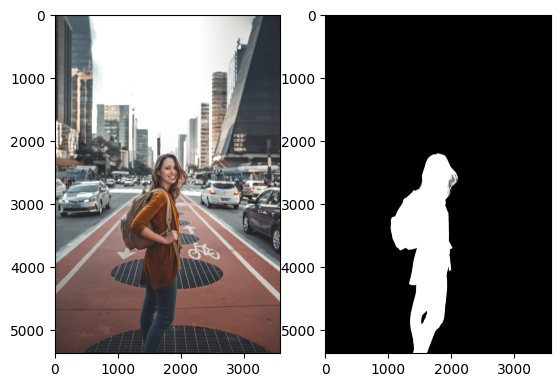

In [1]:
! pip install matplotlib
# check for the fgr_pha.py ForegroundAlphaDataset
from dataset.fgr_phas import ForegroundAlphaDataset
dataset = ForegroundAlphaDataset(((0,1),2))
print(len(dataset))
# visualize the first item
data = dataset[0]
image = data['image']
alpha = data['alpha']
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(alpha, cmap='gray')
plt.show()

<KeysViewHDF5 ['image']>
46839
(448, 448, 3)
0 255


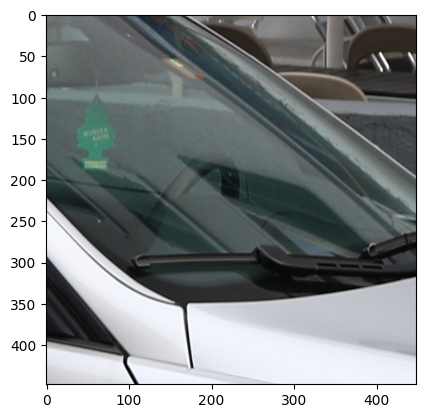

In [2]:
# load the zurich RAW–RGB dataset (Replacing Mobile Camera ISP with a Single Deep Learning Model)
import json,h5py,os
import matplotlib.pyplot as plt 
config_path='dataset/datasets_config.json'
with open(config_path, 'r') as file:
    config = json.load(file)
img_paths = os.path.join(config["data_path"], config['zurich_raw']['train'])
with h5py.File(img_paths, 'r') as file:
    print(file.keys())
    image = file['image'][0]
    print(len(file['image']))
    plt.imshow(image)
    print(image.shape)
    print(image.min(), image.max())

alpha torch.Size([1, 1080, 1920])
fgr_gamma torch.Size([3, 1080, 1920])
bgr_gamma torch.Size([3, 1080, 1920])
fgr_linear torch.Size([3, 1080, 1920])
bgr_linear torch.Size([3, 1080, 1920])
comp_gamma torch.Size([3, 1080, 1920])
comp_linear torch.Size([3, 1080, 1920])
fgrs_linear torch.Size([8, 3, 1080, 1920])
bgrs_linear torch.Size([8, 3, 1080, 1920])
fgrs_gamma torch.Size([8, 3, 1080, 1920])
bgrs_gamma torch.Size([8, 3, 1080, 1920])
alpha_burst torch.Size([8, 1, 1080, 1920])
comp_burst torch.Size([8, 3, 1080, 1920])
comp_burst_gamma torch.Size([8, 3, 1080, 1920])
trimap_burst torch.Size([8, 3, 1080, 1920])


/sensei-fs/users/xcai/conda/envs/rvm/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Figure size 2000x1600 with 0 Axes>

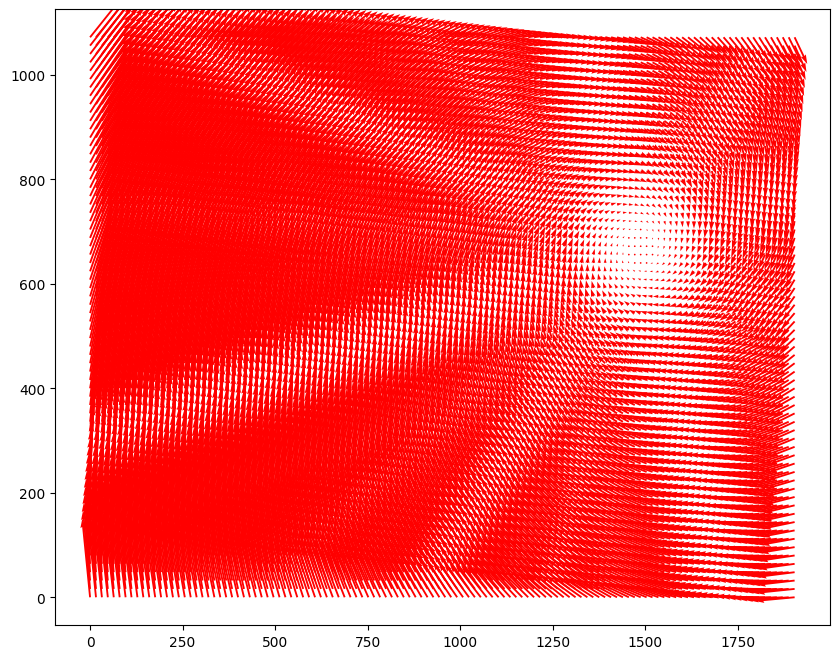

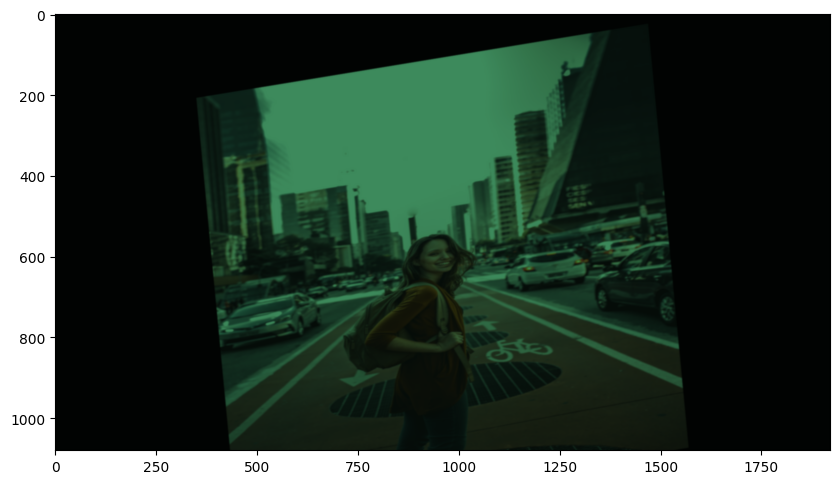

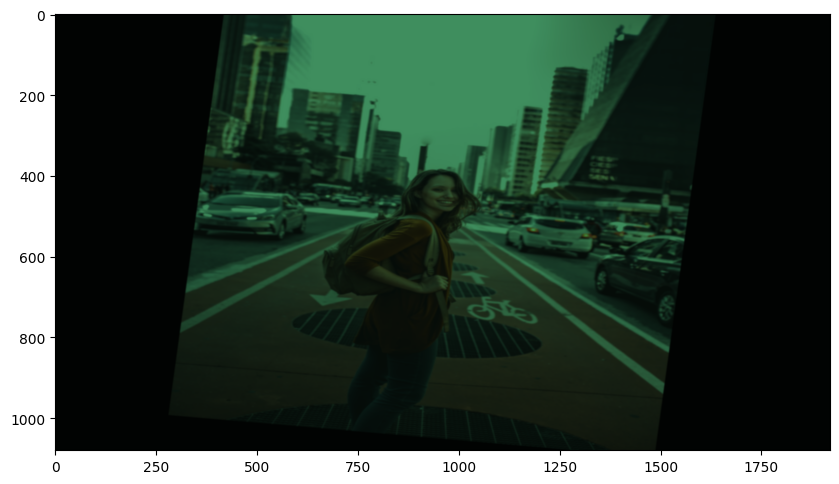

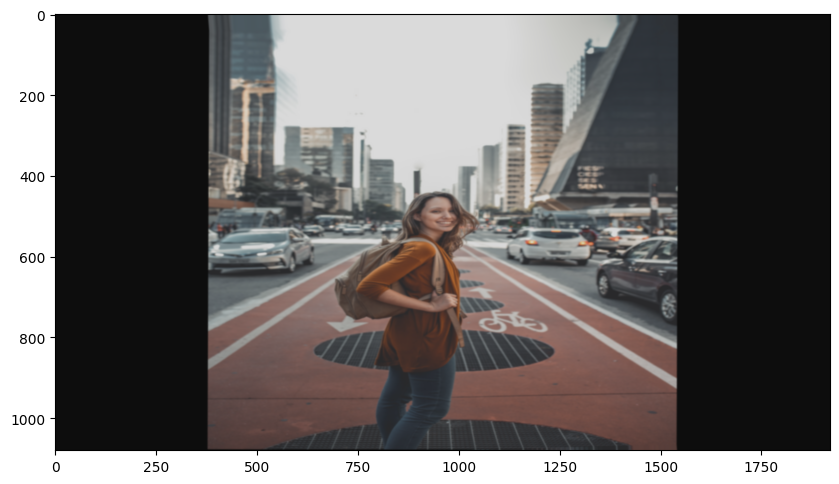

In [1]:
# test the initial version of the synthetic burst dataset
from dataset.synthetic_burst import SyntheticBurstDataset
import gin
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np


from utils.image.synthesis_helper import apply_flow_field

          


gin.parse_config_file('configs/matting/image2burst.gin')
dataset = SyntheticBurstDataset()
import matplotlib.pyplot as plt
from utils.image.rgb2raw import process_linear_image_raw
import torch.nn.functional as F
data = dataset[0]
plt.figure(figsize=(20, 16))
# visualize_shifts(data['metadata']['shifts'])
for key in data.keys():
    if not key.endswith('metadata'):
        print(key, data[key].shape)
        # if key == "fgr_gamma":
        #     plt.imshow(transforms.ToPILImage()(data[key]), interpolation="bicubic")
        # if key == "fgrs_gamma":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "comp_burst":
        #     output = process_linear_rgb_batch(data[key])
        #     grid = make_grid(output, nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "comp_burst":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
        # if key == "phas":
        #     plt.imshow(transforms.ToPILImage()(data[key]), cmap='gray')
        # if key == "comp_burst":
        #     grid = make_grid(data[key], nrow=4, padding=2, normalize=True)
        #     plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")
# visualize the 'fgr_gamma', 'bgr_gamma', 'fgr_linear', 'bgr_linear', 'comp_gamma', 'comp_linear' in one figure
# visual_data = [data[key] for key in ['fgr_gamma', 'bgr_gamma', 'fgr_linear', 'bgr_linear', 'comp_gamma', 'comp_linear']]
# grid = make_grid(visual_data, nrow=2, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")

#visualize the motion flow filed
fgr_flow_fields = data["motion_metadata"]["fgr_flow_fields"]
bgr_flow_fields = data["motion_metadata"]["bgr_flow_fields"]

for fgr_flow_field, bgr_flow_field in zip(fgr_flow_fields, bgr_flow_fields):
    # print(fgr_flow_field.shape, bgr_flow_field.shape)
    pass
    # fgr_flow_field -= fgr_flow_fields[0]
    # bgr_flow_field -= bgr_flow_fields[0]

# flow_color = flow_to_color(fgr_flow_field)
# plt.imshow(flow_color.cpu().numpy(), interpolation="bicubic")

flow = fgr_flow_field.permute(1, 2, 0).numpy()

# 提取 x 和 y 方向的光流分量
u = flow[..., 0]
v = flow[..., 1]
w = u.shape[1]
h = u.shape[0]
# 创建一个网格，用于quiver图的定位点
x_grid, y_grid = np.meshgrid(np.arange(w), np.arange(h))

# 可视化光流字段
plt.figure(figsize=(10, 8))
step = 16  

plt.quiver(x_grid[::step, ::step], y_grid[::step, ::step], u[::step, ::step], v[::step, ::step], angles='xy', scale_units='xy', scale=1, color='r')
# plt.title('Optical Flow Field Visualization with Arrows')
# plt.axis('off')
# plt.show()
plt.savefig("visualization/flow.png")

fgrs_linear = data["fgrs_linear"]
fgrs_gamma = data["fgrs_gamma"]
plt.figure(figsize=(10, 8))
plt.imshow(transforms.ToPILImage()(fgrs_linear[0]), interpolation="bicubic")
plt.savefig("visualization/fgrs_linear_0.png")
plt.figure(figsize=(10, 8))
plt.imshow(transforms.ToPILImage()(fgrs_linear[-1]), interpolation="bicubic")
plt.savefig("visualization/fgrs_linear_-1.png")
plt.figure(figsize=(10, 8))
fgrs_linear_apply_flow = apply_flow_field(fgrs_gamma[4], -fgr_flow_fields[4])
# fgrs_linear_apply_flow = apply_flow_field(fgrs_linear_apply_flow, fgr_flow_fields[0])
plt.imshow(transforms.ToPILImage()(fgrs_linear_apply_flow), interpolation="bicubic")
plt.savefig("visualization/fgrs_linear_apply_flow.png")
# 



# fgr_flow_fields_grid = make_grid(fgr_flow_fields, nrow=4, padding=2, normalize=True)
# bgr_flow_fields_grid = make_grid(bgr_flow_fields, nrow=4, padding=2, normalize=True)

# plt.imshow(transforms.ToPILImage()(fgr_flow_fields_grid),  cmap='hot', interpolation="bicubic")
# data["unprocess_metadata"]["cam2rgb"] = data["unprocess_metadata"]["cam2rgb"][:8]
# print(data["comp_burst"].shape, data["unprocess_metadata"]["cam2rgb"].shape)
# comp_burst = process_linear_image_raw(data["comp_burst"], data["unprocess_metadata"],demosaic=False)
# diff = torch.abs(comp_burst - data["comp_burst_gamma"])
# print(diff.min(), diff.max())
# diff -= diff.min() 
# diff /= diff.max()
# diff_grid = make_grid(diff, nrow=4, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(diff_grid), interpolation="bicubic")
# for_visual = torch.cat([comp_burst, data["comp_burst_gamma"],diff], dim=0)
# grid = make_grid(for_visual, nrow=4, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")

In [16]:
# test the initial version of the synthetic burst dataset
from dataset.synthetic_burst import SyntheticBurstPatch
import gin
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid
import numpy as np
import torch
def visualize_shifts(shift_tensor):
    shifts = shift_tensor.numpy()
    sample_index = 1

    x_shifts = shifts[sample_index, 0, :, :]
    y_shifts = shifts[sample_index, 1, :, :]
    print(x_shifts)
    Y, X = np.mgrid[0:512, 0:512]
    step = 16  
    plt.figure(figsize=(10, 10))
    plt.quiver(X[::step, ::step], Y[::step, ::step], x_shifts[::step, ::step], y_shifts[::step, ::step], 
            angles='xy', scale_units='xy', scale=1)
    plt.gca().invert_yaxis()  

    plt.title(f'Vector field of displacements for sample {sample_index}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.show()

gin.parse_config_file('configs/matting/image2burst.gin')
dataset = SyntheticBurstPatch(patch_size = 250)
import matplotlib.pyplot as plt
from utils.image.rgb2raw import process_linear_image_raw
data = dataset[0]
plt.figure(figsize=(20, 16))
# visualize_shifts(data['metadata']['shifts'])
for key in data.keys():
    if not key.endswith('metadata'):
        print(key, data[key].shape)

data["unprocess_metadata"]["cam2rgb"] = data["unprocess_metadata"]["cam2rgb"][:8]
print(data["comp_burst"].shape, data["unprocess_metadata"]["cam2rgb"].shape)

# find the patch that the trimap is not empty
trimap_burst = data["trimap_burst"]
#find the patch that the trimap have the biggest sum trimap_burst[i,:,1]
sum_list = []
for i in range(trimap_burst.shape[0]):
    sum_list.append(torch.sum(trimap_burst[i,:,1]))
print(sum_list)
i = np.argmax(sum_list)
print(i)
    
comp_burst = process_linear_image_raw(data["comp_burst"][i], data["unprocess_metadata"],demosaic=False)
grid = make_grid(comp_burst, nrow=4, padding=2, normalize=True)
plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")


    # if  torch.sum(trimap_burst[i]) < 250*250*2:
    #     print(i)
    #     break

# data["unprocess_metadata"]["cam2rgb"] = data["unprocess_metadata"]["cam2rgb"][:8]
# print(data["comp_burst"].shape, data["unprocess_metadata"]["cam2rgb"].shape)
# comp_burst = process_linear_image_raw(data["comp_burst"][0], data["unprocess_metadata"],demosaic=False)
# diff = torch.abs(comp_burst - data["comp_burst_gamma"])
# print(diff.min(), diff.max())
# diff -= diff.min() 
# diff /= diff.max()
# diff_grid = make_grid(diff, nrow=4, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(diff_grid), interpolation="bicubic")
# for_visual = torch.cat([comp_burst, data["comp_burst_gamma"],diff], dim=0)
# grid = make_grid(for_visual, nrow=4, padding=2, normalize=True)
# plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic")

alpha torch.Size([1, 1080, 1920])
fgr_gamma torch.Size([3, 1080, 1920])
bgr_gamma torch.Size([3, 1080, 1920])
fgr_linear torch.Size([3, 1080, 1920])
bgr_linear torch.Size([3, 1080, 1920])
comp_gamma torch.Size([3, 1080, 1920])
comp_linear torch.Size([3, 1080, 1920])
fgrs_linear torch.Size([40, 8, 3, 250, 250])
bgrs_linear torch.Size([40, 8, 3, 250, 250])
fgrs_gamma torch.Size([8, 3, 1080, 1920])
bgrs_gamma torch.Size([8, 3, 1080, 1920])
alpha_burst torch.Size([40, 8, 1, 250, 250])
comp_burst torch.Size([40, 8, 3, 250, 250])
comp_burst_gamma torch.Size([8, 3, 1080, 1920])
trimap_burst torch.Size([40, 8, 3, 250, 250])
torch.Size([40, 8, 3, 250, 250]) torch.Size([8, 3, 3])
[tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(11979.), tensor(15190.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(12484.), tensor(20077.), tensor(13063.), tensor(0.), tensor(0.), tensor(0.), 

<Figure size 2000x1600 with 0 Axes>

In [ ]:
#check the dataloader speed of the synthetic burst dataset
import time
from dataset.synthetic_burst import SyntheticBurstDataset
import gin
import torch
gin.parse_config_file('configs/matting/image2burst.gin')
dataset = SyntheticBurstDataset(size = 1024)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)
start = time.time()
for i, data in enumerate(data_loader):
    print(i, time.time()-start)
    start = time.time()
    if i == 100:
        break

: 